#  Coffee Price Prediction Analysis

## Introduction
This notebook aims to analyze historical coffee price indices and develop a predictive model for future price trends. The focus is on using data from the ICO (International Coffee Organization), and the composite indicator price thjat combines the 4 main categories of coffee in the future markets

### Objectives:
1. Clean and preprocess the dataset for missing values and inconsistencies.
2. Explore the time-series behavior of coffee prices through visualizations.
3. Implement various forecasting models to predict future price trends.
4. Compare model performance using key metrics (e.g., RMSE, MAE).

### Dataset:
The dataset used in this analysis consists of historical coffee price data, with daily observations for business days. Prices are expressed in cents of USD.

### Tools & Libraries:
- **Python**: For data manipulation and model building.
- **Pandas**: For data handling and preprocessing.
- **Matplotlib & Plotly**: For visualizations.
- **Scikit-learn & Statsmodels**: For predictive modeling.

### Expected Outcome:
By the end of this notebook, we will identify the best forecasting model for coffee prices and present actionable insights based on the findings.

In [1]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #dataframes 
import numpy as np #linear algebra
import seaborn as sns #visualization
sns.set(color_codes=True)


import plotly.express as px
import plotly.graph_objects as go


import scipy.stats as stats #statistical resources

import matplotlib.pyplot as plt #visualisation 
%matplotlib inline 


from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl

from sklearn.model_selection import train_test_split # importing function to split the data training and test.
from sklearn.preprocessing import MinMaxScaler # Import the MinMaxScaler module from sklearn.preprocessing library
from sklearn.linear_model import LinearRegression # importing to performe linear regression. 
from sklearn.metrics import make_scorer, r2_score # Importing from Metrics module
from sklearn.preprocessing import StandardScaler # standardize the data
from sklearn import metrics # Metrics module from scikit-learn
from sklearn.model_selection import GridSearchCV # importing for hyperparameter tunning
from sklearn.metrics import mean_squared_error # importing mse
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #last update in python causing dead kernel wehn importing keras functions?
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.interpolate import interp1d

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit



from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## 1. Loading data
Using dataframe with pre-processed data on separate Jupyter Notebook


433 rows containing original prices, standardised prices, normalised, differentiated values and 4 time-based features (DayOfWeek	|WeekOfYear	|Month	|Quarter)

In [2]:
df = pd.read_csv('processed_data.csv', index_col='date', parse_dates=True)

In [3]:
df

,I-CIP,price_standardized,price_normalized,price_diff,I-CIP_Standardised
date,,,,,
2023-02-02,172.50,-0.482921,0.209218,1.07,0.209218
2023-02-03,169.47,-0.578568,0.185305,-3.03,0.185305
2023-02-06,171.29,-0.521117,0.199669,1.82,0.199669
2023-02-07,172.14,-0.494285,0.206377,0.85,0.206377
2023-02-08,171.23,-0.523011,0.199195,-0.91,0.199195
...,...,...,...,...,...
2024-09-24,269.83,2.589469,0.977350,3.05,0.977350
2024-09-25,270.09,2.597677,0.979402,0.26,0.979402
2024-09-26,272.70,2.680066,1.000000,2.61,1.000000


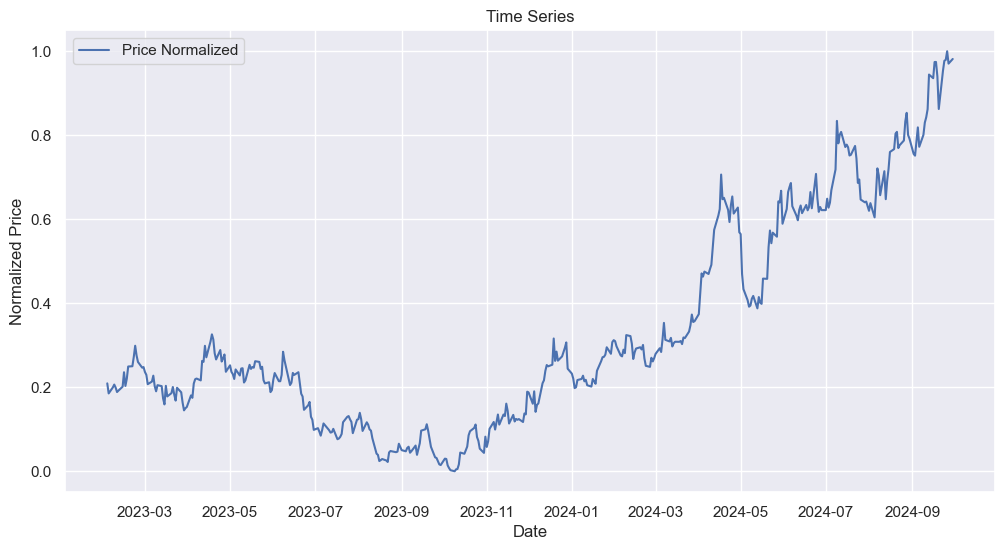

In [4]:
# Select the target column for time series analysis
target_col = 'price_normalized'

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df[target_col], label='Price Normalized')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## 2. Data prep for SARIMA


### 2.1 Cheking for stationarity
 for both normalised data (will mantain data structure, but only in a smaller scale from 0 to 1) and diff values

In [5]:
# ADF Test for Stationarity
result = adfuller(df[target_col])
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Test Statistic: 1.6593577893936908
p-value: 0.9980251657535798
Critical Values: {'1%': -3.446205926287236, '5%': -2.8685297226414734, '10%': -2.570493298011322}


In [6]:
# Select the differentiated column for SARIMA
df_sarima = df[['price_diff']]

#### Shapiro-Wilk test for normality of diff_prices


In [7]:
from scipy.stats import shapiro

def check_normality(series):
    stat, p_value = shapiro(series)
    print(f'Shapiro-Wilk Test Statistic: {stat}')
    print(f'p-value: {p_value}')

    if p_value < 0.05:
        print("The data does not appear to be normally distributed.")
    else:
        print("The data appears to be normally distributed.")

# Example usage:
check_normality(df_sarima)

Shapiro-Wilk Test Statistic: 0.9792444109916687
p-value: 7.385493972833501e-06
The data does not appear to be normally distributed.


In [8]:
# checkin stationarity for diff prices
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

check_stationarity(df_sarima)


ADF Statistic: -7.472991901655821
p-value: 4.997709416514464e-11
Critical Value 1%: -3.445757604526768
Critical Value 5%: -2.8683325885102855
Critical Value 10%: -2.5703882165206853


In [9]:


# Drop NaN values caused by differentiation (from 434 to 433 total obs)
df_sarima = df_sarima.dropna()

# Display the cleaned data
print(df_sarima.head())

            price_diff
date                  
2023-02-02        1.07
2023-02-03       -3.03
2023-02-06        1.82
2023-02-07        0.85
2023-02-08       -0.91


In [10]:
df_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 2023-02-02 to 2024-09-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_diff  433 non-null    float64
dtypes: float64(1)
memory usage: 6.8 KB


Checking Differentiated prices time series shape


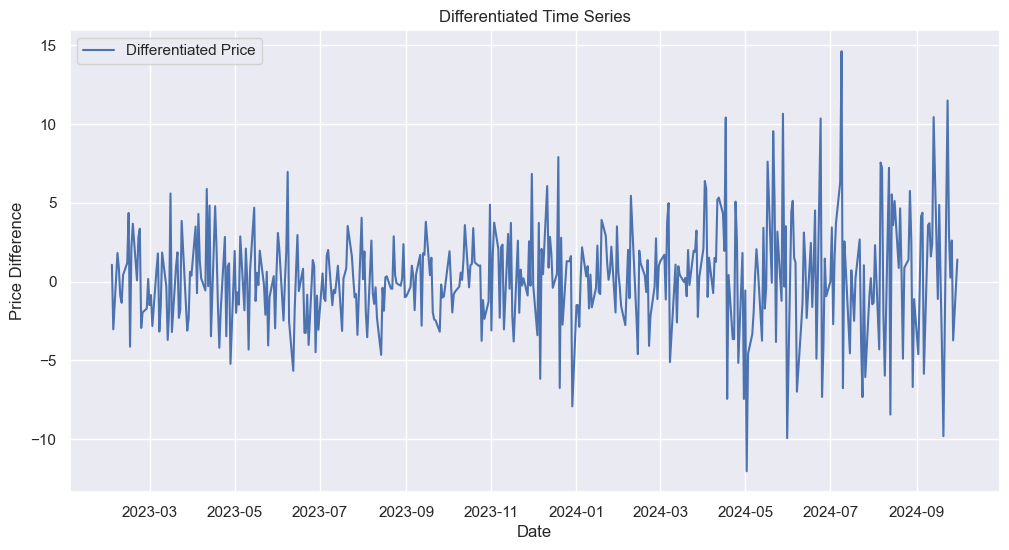

In [11]:
# Plot the differentiated series
plt.figure(figsize=(12, 6))
plt.plot(df_sarima, label='Differentiated Price')
plt.title('Differentiated Time Series')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

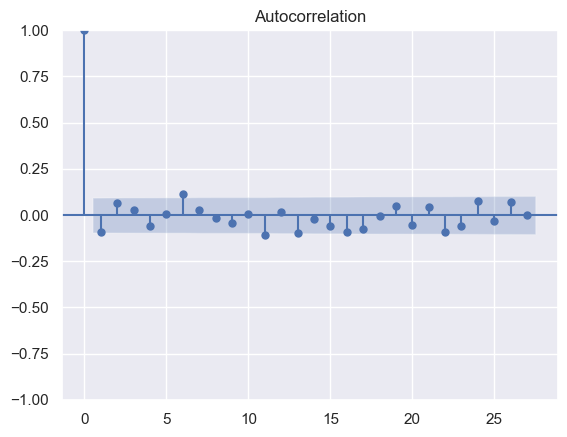

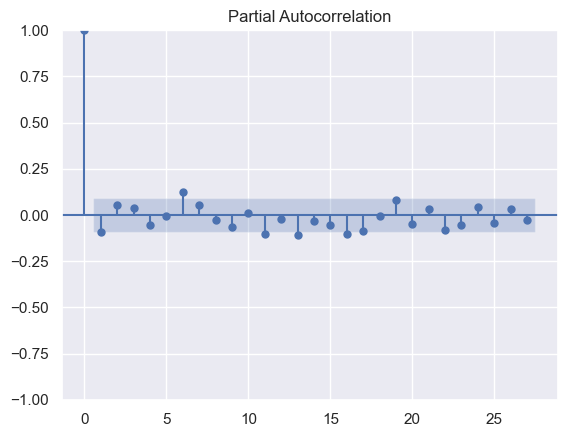

In [12]:
#acf plot for correlation
plot_acf(df_sarima.dropna())
plt.show()

# partial correlation 
plot_pacf(df_sarima.dropna())
plt.show()

 ## Build dictionary to store all metrics from the modeling

In [13]:
# Initialise a dictionary to store error metrics
model_results = {}

# Function to add new results to the dictionary
def add_model_results(model_name, mse, mae, rmse, mape):
    """
    Adds model performance metrics to the results dictionary.
    """
    model_results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Example: Adding a placeholder for Linear Regression results
add_model_results("Linear Regression", mse=0.0037, mae=0.0469, rmse=0.0612, mape=6.25)

# Print the initial dictionary
print("Initial Model Results:")
print(model_results)

Initial Model Results:
{'Linear Regression': {'MSE': 0.0037, 'MAE': 0.0469, 'RMSE': 0.0612, 'MAPE': 6.25}}


In [14]:
df_sarima

,price_diff
date,
2023-02-02,1.07
2023-02-03,-3.03
2023-02-06,1.82
2023-02-07,0.85
2023-02-08,-0.91
...,...
2024-09-24,3.05
2024-09-25,0.26
2024-09-26,2.61


### 2.2 Splitting Train-Test for SARIMA

SARIMA models require preserving the temporal order of the time series, however, since they are models specific made for capturing seasonality, there is no exaclty need to create a timeseries sequence. At first experimentation, will use a ratio for 80% training and 20% testing



as SARIMA handles the temporal structure internally.

In [15]:
# Define train-test split ratio
train_ratio = 0.8
train_size = int(len(df_sarima) * train_ratio)

# Split into train and test sets
train_data = df_sarima.iloc[:train_size]
test_data = df_sarima.iloc[train_size:]

# Print sizes
print(f"Training Set Size: {len(train_data)}")
print(f"Testing Set Size: {len(test_data)}")

Training Set Size: 346
Testing Set Size: 87


training set from 02/02/23 to 30/05/24

In [16]:
train_data

,price_diff
date,
2023-02-02,1.07
2023-02-03,-3.03
2023-02-06,1.82
2023-02-07,0.85
2023-02-08,-0.91
...,...
2024-05-24,3.18
2024-05-27,-1.22
2024-05-28,10.66


testing set form 31/05/24 to 30/09/24


In [17]:
test_data

,price_diff
date,
2024-05-31,-9.94
2024-06-03,4.42
2024-06-04,5.13
2024-06-05,1.51
2024-06-06,1.22
...,...
2024-09-24,3.05
2024-09-25,0.26
2024-09-26,2.61


### 2.3 Fit SARIMA 

### a. Fit basic SARIMA

 using diff values and m=5

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [19]:
# Fit SARIMA model on training data
model = SARIMAX(train_data, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 5))
sarima_result = model.fit()

# Print model summary
print(sarima_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66889D+00    |proj g|=  8.46609D-02


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.49484D+00    |proj g|=  2.95639D-02

At iterate   10    f=  2.47862D+00    |proj g|=  1.44167D-02

At iterate   15    f=  2.47159D+00    |proj g|=  3.80449D-03

At iterate   20    f=  2.47121D+00    |proj g|=  2.43148D-03

At iterate   25    f=  2.47118D+00    |proj g|=  2.76654D-04

At iterate   30    f=  2.47118D+00    |proj g|=  2.35988D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  2.47118D+00    |proj g|=  3.21343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     61      2     0     0   3.213D-06   2.471D+00
  F =   2.4711769953857967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                        price_diff   No. Observations:                  346
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -855.027
Date:                           Sat, 23 Nov 2024   AIC                           1720.054
T

### Forecast and evaluate


In [20]:
# Forecast on the test set
forecast = sarima_result.forecast(steps=len(test_data))

# Calculate error metrics
mse_sarima = mean_squared_error(test_data, forecast)
mae_sarima = mean_absolute_error(test_data, forecast)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test_data.values.flatten() - forecast) / test_data.values.flatten())) * 100

# Print metrics
print(f"SARIMA Performance:\nMSE: {mse_sarima:.4f}\nMAE: {mae_sarima:.4f}\nRMSE: {rmse_sarima:.4f}\nMAPE: {mape_sarima:.2f}%")

# Add metrics to the dictionary
add_model_results("SARIMA", mse=mse_sarima, mae=mae_sarima, rmse=rmse_sarima, mape=mape_sarima)

SARIMA Performance:
MSE: 22.0944
MAE: 3.6516
RMSE: 4.7005
MAPE: inf%


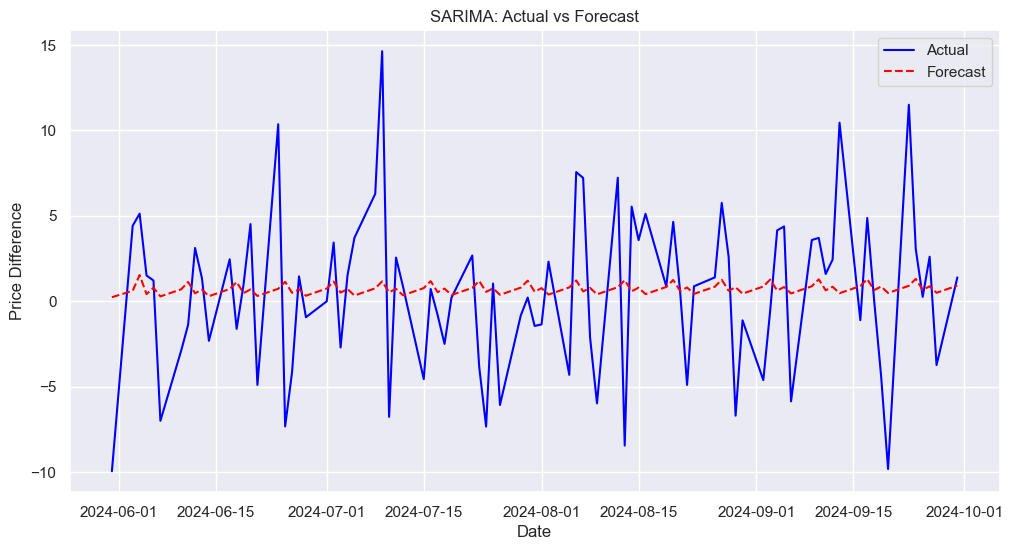

In [21]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('SARIMA: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


### b) SARIMA with weekly seasonality


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61182D+00    |proj g|=  1.02142D-01

At iterate    5    f=  2.43365D+00    |proj g|=  1.51920D-01
  ys=-2.468E-03  -gs= 4.610E-03 BFGS update SKIPPED

At iterate   10    f=  2.41790D+00    |proj g|=  2.10307D-01

At iterate   15    f=  2.41743D+00    |proj g|=  8.64288D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     47      1     1     0   8.643D-04   2.417D+00
  F =   2.4174319987803590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                        price_diff   No. Observations:                  346
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -836.431
Date:                           Sat, 23 Nov 2024   AIC                           1682.863
Time:                                   15:23:38   BIC         

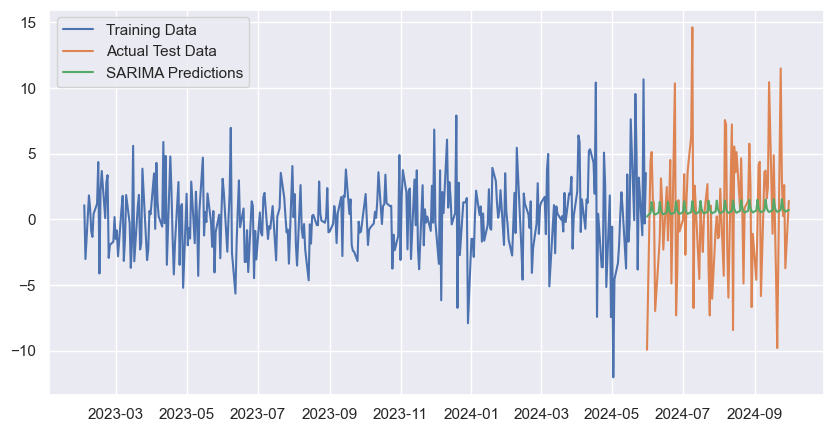

SARIMA Performance:
MSE: 22.2404
MAE: 3.6827
RMSE: 4.7160
MAPE: inf%


In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Define SARIMA model parameters

p = 1  # Non-seasonal AR order
d = 1  # Non-seasonal differencing
q = 1  # Non-seasonal MA order
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
m = 5  # Seasonal period (5 for weekly seasonality)

# Initialize the model
sarima_model = SARIMAX(train_data,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Summary of the model
print(sarima_result.summary())

# Make predictions on the test set
predictions = sarima_result.get_forecast(steps=len(test_data))
predicted_means = predictions.predicted_mean

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data')
plt.plot(test_data.index, predicted_means, label='SARIMA Predictions')
plt.legend()
plt.show()


# Calculate error metrics
mse_sarima = mean_squared_error(test_data, predicted_means)
mae_sarima = mean_absolute_error(test_data, predicted_means)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test_data.values.flatten() - forecast) / test_data.values.flatten())) * 100

# Print metrics
print(f"SARIMA Performance:\nMSE: {mse_sarima:.4f}\nMAE: {mae_sarima:.4f}\nRMSE: {rmse_sarima:.4f}\nMAPE: {mape_sarima:.2f}%")

# Add metrics to the dictionary
add_model_results("SARIMA (diff; m=5)", mse=mse_sarima, mae=mae_sarima, rmse=rmse_sarima, mape=mape_sarima)



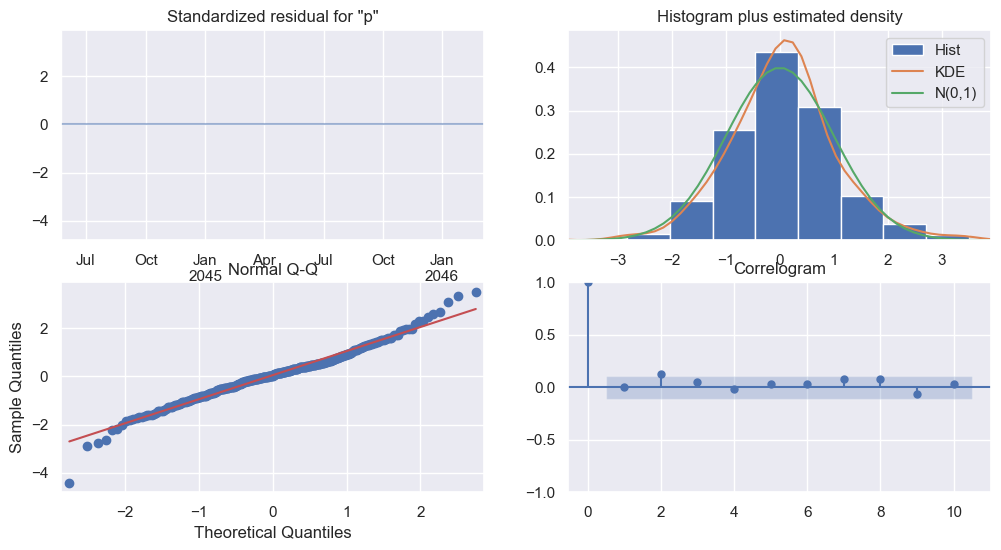

In [23]:

# run diagnostics
sarima_result.plot_diagnostics(figsize=(12, 6))

plt.show()

The first application of sarima indicates the model is not really perfoming well yet. 


next will use a m=21 for montly seasonality and compare. other parameters need to be revised.

### c) Sarima with m=21


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36942D+00    |proj g|=  1.08006D-01


 This problem is unconstrained.



At iterate    5    f=  2.24189D+00    |proj g|=  1.55293D-01

At iterate   10    f=  2.23170D+00    |proj g|=  8.08403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.328D-06   2.232D+00
  F =   2.2317028833638819     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                         price_diff   No. Observations:                  346
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood                -772.169
Date:                     

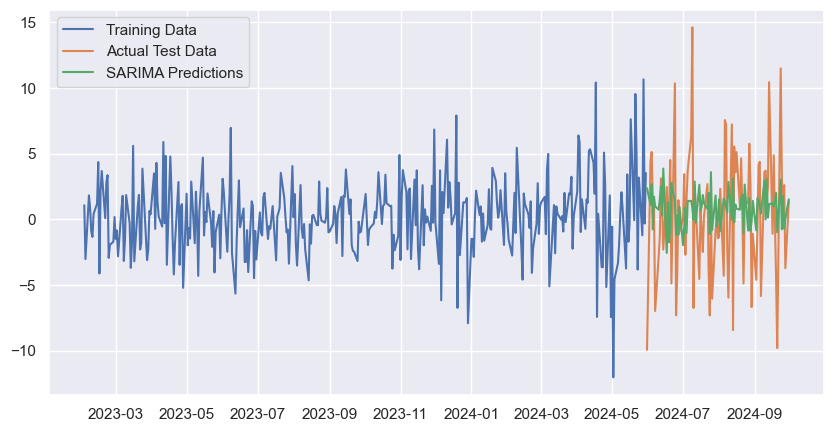

SARIMA Performance:
MSE: 23.9829
MAE: 4.0098
RMSE: 4.8972
MAPE: inf%


In [24]:
# Define SARIMA model parameters

p = 1  # Non-seasonal AR order
d = 1  # Non-seasonal differencing
q = 1  # Non-seasonal MA order
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
m = 21  # Seasonal period (21 for montly seasonality)

# Initialize the model
sarima_model = SARIMAX(train_data,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Summary of the model
print(sarima_result.summary())

# Make predictions on the test set
predictions = sarima_result.get_forecast(steps=len(test_data))
predicted_means = predictions.predicted_mean

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data')
plt.plot(test_data.index, predicted_means, label='SARIMA Predictions')
plt.legend()
plt.show()


# Calculate error metrics
mse_sarima = mean_squared_error(test_data, predicted_means)
mae_sarima = mean_absolute_error(test_data, predicted_means)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test_data.values.flatten() - forecast) / test_data.values.flatten())) * 100

# Print metrics
print(f"SARIMA Performance:\nMSE: {mse_sarima:.4f}\nMAE: {mae_sarima:.4f}\nRMSE: {rmse_sarima:.4f}\nMAPE: {mape_sarima:.2f}%")

# Add metrics to the dictionary
add_model_results("SARIMA (diff; m=21)", mse=mse_sarima, mae=mae_sarima, rmse=rmse_sarima, mape=mape_sarima)



### d) SARIMA with Grid Search for best param (m=5)

In [25]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [26]:
# Define parameter ranges
p = d = q = range(0, 3)  # AR, Differencing, MA orders
P = D = Q = range(0, 2)  # Seasonal AR, Differencing, MA orders
m = [5]  # Seasonal periods (weekly)

# Generate all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, m))

# Grid search
best_aic = float("inf")
best_params = None
for params in param_combinations:
    try:
        model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        if result.aic < best_aic:
            best_aic = result.aic
            best_params = params
    except:
        continue

print(f"Best Parameters: {best_params}, AIC: {best_aic}")

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/t

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/t

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

Best Parameters: (0, 0, 2, 0, 1, 1, 5), AIC: 1667.892290799393


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50817D+00    |proj g|=  1.43960D-01

At iterate    5    f=  2.40391D+00    |proj g|=  9.32558D-02

At iterate   10    f=  2.39869D+00    |proj g|=  1.12477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.214D-06   2.399D+00
  F =   2.3986882815020132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                 

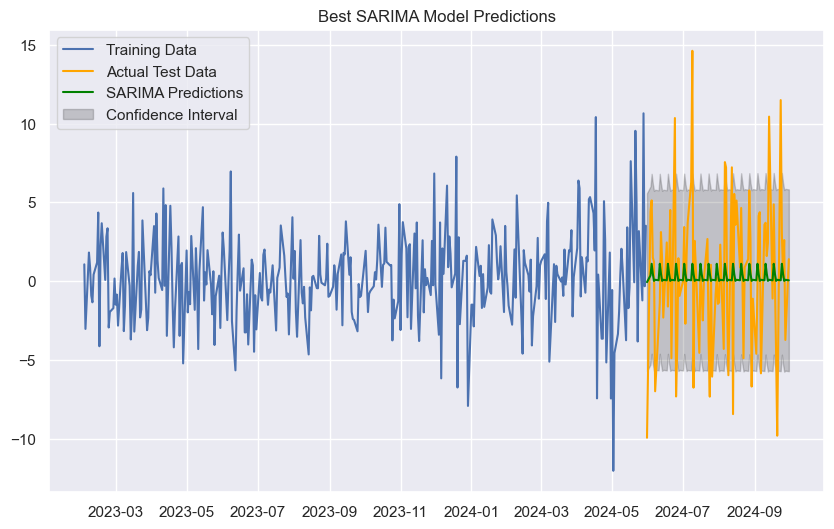

Best SARIMA Performance:
MSE: 22.2940
MAE: 3.7162
RMSE: 4.7216
MAPE: inf%


In [27]:


# Best parameters from grid search
best_order = (0, 0, 2)  # p, d, q
best_seasonal_order = (0, 1, 1, 5)  # P, D, Q, m

# Initialize the SARIMA model with the best parameters
best_sarima_model = SARIMAX(train_data,
                            order=best_order,
                            seasonal_order=best_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

# Fit the model
best_sarima_result = best_sarima_model.fit()

# Summary of the model
print(best_sarima_result.summary())

# Forecast on the test set
forecast = best_sarima_result.get_forecast(steps=len(test_data))
predicted_means = forecast.predicted_mean
conf_int = forecast.conf_int()  # Confidence intervals

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(test_data.index, predicted_means, label='SARIMA Predictions', color='green')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Best SARIMA Model Predictions")
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data, predicted_means)
mae = mean_absolute_error(test_data, predicted_means)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data.values.flatten() - predicted_means) / test_data.values.flatten())) * 100

print(f"Best SARIMA Performance:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Add metrics to the results dictionary
add_model_results("SARIMA (Best Grid Search)", mse=mse, mae=mae, rmse=rmse, mape=mape)


### e) SARIMA - grid search for m=21

In [28]:
# Define parameter ranges
p = d = q = range(0, 3)  # AR, Differencing, MA orders
P = D = Q = range(0, 2)  # Seasonal AR, Differencing, MA orders
m = [21]  # Seasonal periods (montly)

# Generate all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, m))

# Grid search
best_aic = float("inf")
best_params = None
for params in param_combinations:
    try:
        model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        if result.aic < best_aic:
            best_aic = result.aic
            best_params = params
    except:
        continue

print(f"Best Parameters: {best_params}, AIC: {best_aic}")

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

Best Parameters: (0, 0, 2, 0, 1, 1, 21), AIC: 1537.7643887512834


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28647D+00    |proj g|=  9.66365D-02


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.21067D+00    |proj g|=  4.84621D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   5.351D-06   2.211D+00
  F =   2.2106421802764209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:                           price_diff   No. Observations:                  346
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 21)   Log Likelihood                -764.882
Date:                              Sat, 23 Nov 2024   AIC                         

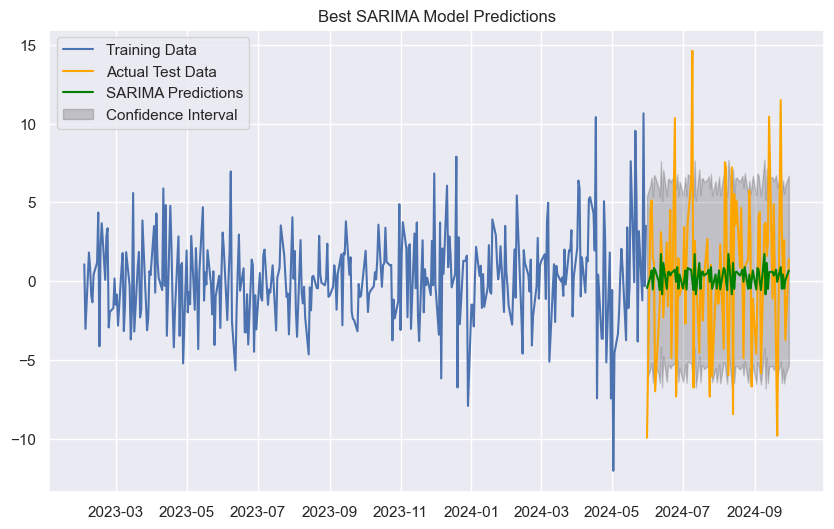

Best SARIMA Performance:
MSE: 22.9100
MAE: 3.7901
RMSE: 4.7864
MAPE: inf%


In [29]:


# Best parameters from grid search
best_order = (0, 0, 2)  # p, d, q
best_seasonal_order = (0, 1, 1, 21)  # P, D, Q, m

# Initialize the SARIMA model with the best parameters
best_sarima_model = SARIMAX(train_data,
                            order=best_order,
                            seasonal_order=best_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

# Fit the model
best_sarima_result = best_sarima_model.fit()

# Summary of the model
print(best_sarima_result.summary())

# Forecast on the test set
forecast = best_sarima_result.get_forecast(steps=len(test_data))
predicted_means = forecast.predicted_mean
conf_int = forecast.conf_int()  # Confidence intervals

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(test_data.index, predicted_means, label='SARIMA Predictions', color='green')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Best SARIMA Model Predictions")
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data, predicted_means)
mae = mean_absolute_error(test_data, predicted_means)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data.values.flatten() - predicted_means) / test_data.values.flatten())) * 100

print(f"Best SARIMA Performance:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Add metrics to the results dictionary
add_model_results("SARIMA (Best Grid Search m=21)", mse=mse, mae=mae, rmse=rmse, mape=mape)


In [30]:
model_results

{'Linear Regression': {'MSE': 0.0037,
  'MAE': 0.0469,
  'RMSE': 0.0612,
  'MAPE': 6.25},
 'SARIMA': {'MSE': 22.094367724952193,
  'MAE': 3.6516118608826784,
  'RMSE': 4.700464628624727,
  'MAPE': inf},
 'SARIMA (diff; m=5)': {'MSE': 22.24036595101825,
  'MAE': 3.6827261080175724,
  'RMSE': 4.7159692483113425,
  'MAPE': inf},
 'SARIMA (diff; m=21)': {'MSE': 23.98292853445621,
  'MAE': 4.009793326401919,
  'RMSE': 4.897236826462062,
  'MAPE': inf},
 'SARIMA (Best Grid Search)': {'MSE': 22.293957607777305,
  'MAE': 3.7162461198564034,
  'RMSE': 4.721647764052006,
  'MAPE': inf},
 'SARIMA (Best Grid Search m=21)': {'MSE': 22.909985100073268,
  'MAE': 3.7900504968405055,
  'RMSE': 4.7864376210364705,
  'MAPE': inf}}

Using only normalised values (on a smaller scale from 0 to 1) and inclusing the diff values as exogenous variable?


### f) SARIMA with scaled data (addind diff values as exogenoius varibale)

In [31]:
# Split the dataset into training and test sets
train_data = df['price_normalized'][:'2024-05-30']
test_data = df['price_normalized']['2024-06-01':]

# Extract the exogenous feature (price_diff)
train_exog = df['price_diff'][:'2024-05-30']
test_exog = df['price_diff']['2024-06-01':]


In [32]:
# Define SARIMA model parameters
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 5  # Weekly seasonality

# Initialize the model with exogenous features
sarima_model = SARIMAX(train_data,
                       exog=train_exog,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Print the summary
print(sarima_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.72254D+00    |proj g|=  2.00681D+01

At iterate    5    f= -2.76289D+00    |proj g|=  2.84698D-01

At iterate   10    f= -2.76598D+00    |proj g|=  6.02412D+00

At iterate   15    f= -2.80783D+00    |proj g|=  5.22211D+01


/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f= -2.82184D+00    |proj g|=  4.98772D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     45      1     0     0   2.647D+01  -2.822D+00
  F =  -2.8218692593742705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                  price_normalized   No. Observations:                  346
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                 976.367
Date:                           Sat, 23 Nov 2024   AIC                          -1940.734
T


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


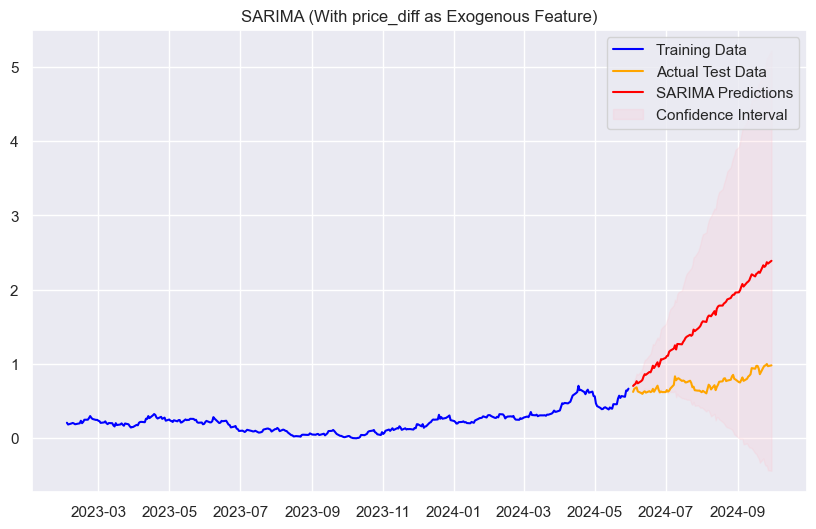

In [33]:
# Forecast with the test set's exogenous variable
forecast = sarima_result.get_forecast(steps=len(test_data), exog=test_exog)
predicted_means = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(test_data.index, predicted_means, label='SARIMA Predictions', color='red')
plt.fill_between(test_data.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("SARIMA (With price_diff as Exogenous Feature)")
plt.show()

In [34]:
# Calculate error metrics
mse = mean_squared_error(test_data, predicted_means)
mae = mean_absolute_error(test_data, predicted_means)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data.values - predicted_means) / test_data.values)) * 100

# Print metrics
print(f"SARIMA Performance:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Add to the results dictionary
add_model_results("SARIMA (Normalized + price_diff)", mse=mse, mae=mae, rmse=rmse, mape=mape)


SARIMA Performance:
MSE: 0.7976
MAE: 0.7925
RMSE: 0.8931
MAPE: 103.03%


## 2.4 AutoARIMA using scaled data


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-1632.511, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-1629.900, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-1629.698, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-1633.318, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-1631.053, Time=0.36 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-1631.010, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-1629.130, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-1631.327, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-1631.166, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-1630.605, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 2.241 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  346
Model:               SARIMAX(0, 1, 0)   Log Likeliho

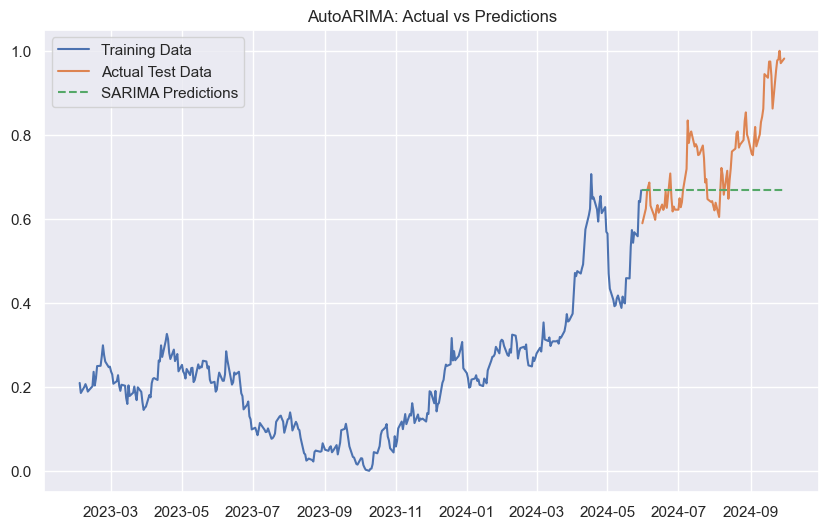

MSE: 0.0183
MAE: 0.1018
RMSE: 0.1355
MAPE: 12.45%


In [35]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Split data
train, test = train_test_split(df['price_normalized'], test_size=0.2, shuffle=False)

# Run AutoARIMA
auto_model = auto_arima(
    train,
    seasonal=True,
    m=5,  # Weekly seasonality
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None, D=None,  # Let AutoARIMA determine differencing
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic'
)

# Print best model summary
print(auto_model.summary())

# Forecast
forecast = auto_model.predict(n_periods=len(test))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Predictions', linestyle='--')
plt.legend()
plt.title('AutoARIMA: Actual vs Predictions')
plt.show()

# Evaluate performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print metrics
print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Store results
add_model_results('AutoARIMA (Normalized)', mse, mae, rmse, mape)


m=21 (auto arima)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=-1632.511, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=-1634.207, Time=1.39 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=-1633.311, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=-1633.318, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[21] intercept   : AIC=-1631.327, Time=0.30 sec
 ARIMA(1,1,0)(2,0,0)[21] intercept   : AIC=-1633.246, Time=43.99 sec
 ARIMA(1,1,0)(1,0,1)[21] intercept   : AIC=-1632.665, Time=4.27 sec
 ARIMA(1,1,0)(0,0,1)[21] intercept   : AIC=-1633.608, Time=2.26 sec
 ARIMA(1,1,0)(2,0,1)[21] intercept   : AIC=-1632.027, Time=9.88 sec
 ARIMA(0,1,0)(1,0,0)[21] intercept   : AIC=-1634.699, Time=1.41 sec
 ARIMA(0,1,0)(2,0,0)[21] intercept   : AIC=-1633.904, Time=4.91 sec
 ARIMA(0,1,0)(1,0,1)[21] intercept   : AIC=-1633.197, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[21] intercept   : AIC=-1634.172, Time=0.78 sec
 ARIMA(0,1,0)(2,0,1)[21] intercept   : AIC=-1632.394, Time=4.24 sec
 ARI

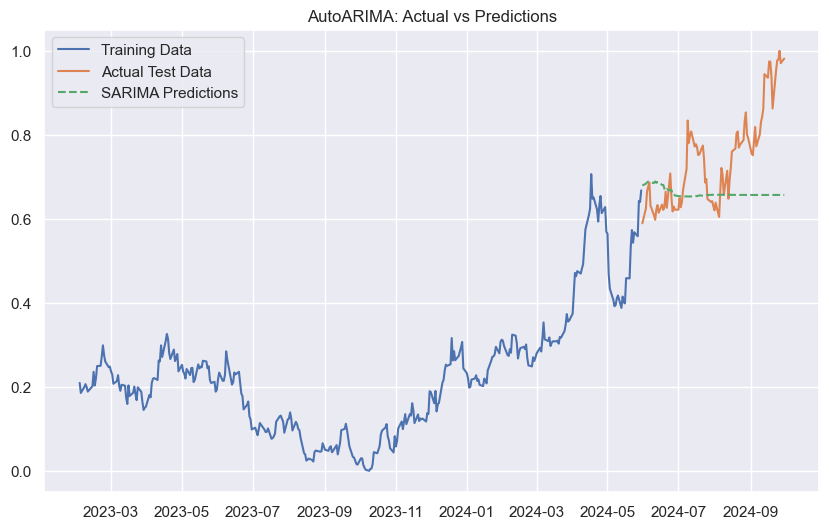

MSE: 0.0206
MAE: 0.1087
RMSE: 0.1434
MAPE: 13.32%


In [36]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Split data
train, test = train_test_split(df['price_normalized'], test_size=0.2, shuffle=False)

# Run AutoARIMA
auto_model = auto_arima(
    train,
    seasonal=True,
    m=21,  # Montly seasonality
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None, D=None,  # Let AutoARIMA determine differencing
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic'
)

# Print best model summary
print(auto_model.summary())

# Forecast
forecast = auto_model.predict(n_periods=len(test))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Predictions', linestyle='--')
plt.legend()
plt.title('AutoARIMA: Actual vs Predictions')
plt.show()

# Evaluate performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print metrics
print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Store results
add_model_results('AutoARIMA (Normalized m=21)', mse, mae, rmse, mape)


## m=63

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[63] intercept   : AIC=-1632.511, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[63] intercept   : AIC=-1630.817, Time=6.17 sec
 ARIMA(0,1,1)(0,0,1)[63] intercept   : AIC=-1630.838, Time=13.44 sec
 ARIMA(0,1,0)(0,0,0)[63]             : AIC=-1633.318, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[63] intercept   : AIC=-1632.082, Time=2.62 sec
 ARIMA(0,1,0)(0,0,1)[63] intercept   : AIC=-1632.260, Time=7.65 sec
 ARIMA(0,1,0)(1,0,1)[63] intercept   : AIC=-1630.351, Time=6.13 sec
 ARIMA(1,1,0)(0,0,0)[63] intercept   : AIC=-1631.327, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[63] intercept   : AIC=-1631.166, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[63] intercept   : AIC=-1630.605, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[63]          
Total fit time: 36.443 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  346
Model:               SARIMAX(0, 1, 0)  

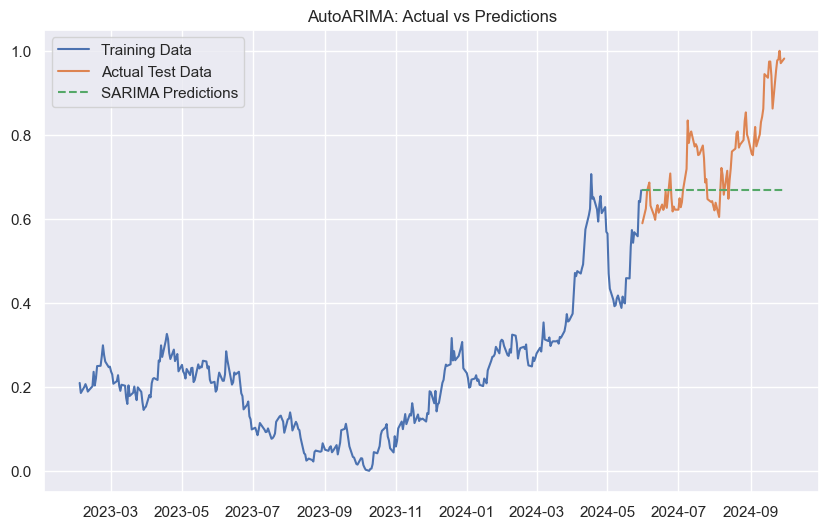

MSE: 0.0183
MAE: 0.1018
RMSE: 0.1355
MAPE: 12.45%


In [37]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Split data
train, test = train_test_split(df['price_normalized'], test_size=0.2, shuffle=False)

# Run AutoARIMA
auto_model = auto_arima(
    train,
    seasonal=True,
    m=63,  # Weekly seasonality
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None, D=None,  # Let AutoARIMA determine differencing
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic'
)

# Print best model summary
print(auto_model.summary())

# Forecast
forecast = auto_model.predict(n_periods=len(test))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Predictions', linestyle='--')
plt.legend()
plt.title('AutoARIMA: Actual vs Predictions')
plt.show()

# Evaluate performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print metrics
print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

# Store results
add_model_results('AutoARIMA (Normalized m=63)', mse, mae, rmse, mape)


## 2.5 SARIMA with cross validation

 m=5
 
 m=21
 
 and m=63?
 
Using TimeSeriesSplit for keeping the temporal order of data for splitting into training, testing and validation sets

using scaled values

In [38]:
# Ensure your normalised dataset is ready
data = df['price_normalized']  # 
m = 5  # Seasonality (weekly)

In [39]:
# Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q = 1, 1, 1

# Initialize lists to store metrics
cv_mse, cv_mae, cv_rmse = [], [], []

# Perform TimeSeriesSplit cross-validation
for train_index, val_index in tscv.split(data):
    train_data, val_data = data.iloc[train_index], data.iloc[val_index]

    # Fit SARIMA on training set
    model = SARIMAX(train_data,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, m),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)

    # Forecast for validation set
    forecast = sarima_fit.forecast(steps=len(val_data))

    # Calculate error metrics
    mse = mean_squared_error(val_data, forecast)
    mae = mean_absolute_error(val_data, forecast)
    rmse = np.sqrt(mse)

    # Store the metrics
    cv_mse.append(mse)
    cv_mae.append(mae)
    cv_rmse.append(rmse)

# Print cross-validation results
print("Cross-Validation Results:")
print(f"Mean MSE: {np.mean(cv_mse):.4f} ± {np.std(cv_mse):.4f}")
print(f"Mean MAE: {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}")
print(f"Mean RMSE: {np.mean(cv_rmse):.4f} ± {np.std(cv_rmse):.4f}")

# Store cross-validation results in your metrics dictionary
add_model_results(
    model_name="SARIMA (Cross-Validation)",
    mse=np.mean(cv_mse),
    mae=np.mean(cv_mae),
    rmse=np.mean(cv_rmse),
    mape=None  # MAPE can be added if required
)

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

Cross-Validation Results:
Mean MSE: 0.0187 ± 0.0152
Mean MAE: 0.1056 ± 0.0442
Mean RMSE: 0.1269 ± 0.0510


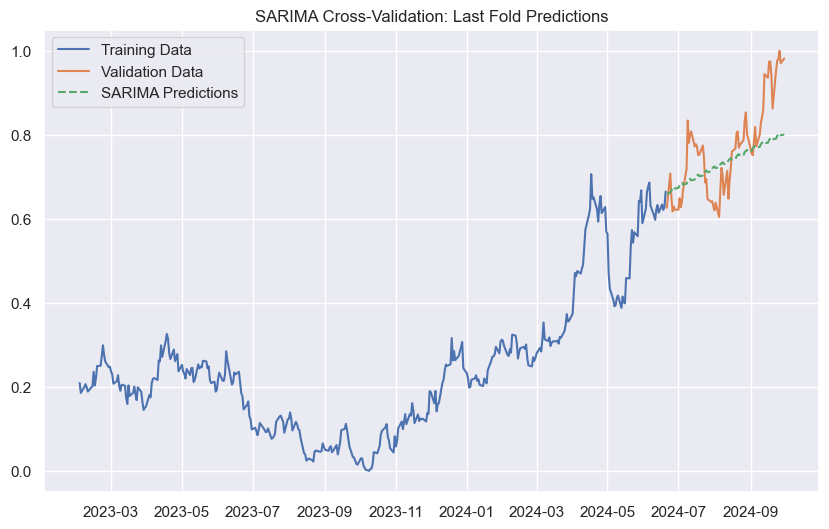

In [40]:
#  Visualize the last fold's predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data, label="Training Data")
plt.plot(val_data, label="Validation Data")
plt.plot(val_data.index, forecast, label="SARIMA Predictions", linestyle="--")
plt.title("SARIMA Cross-Validation: Last Fold Predictions")
plt.legend()
plt.show()

### 2.5 a) Tuning Parameters for SARIMA

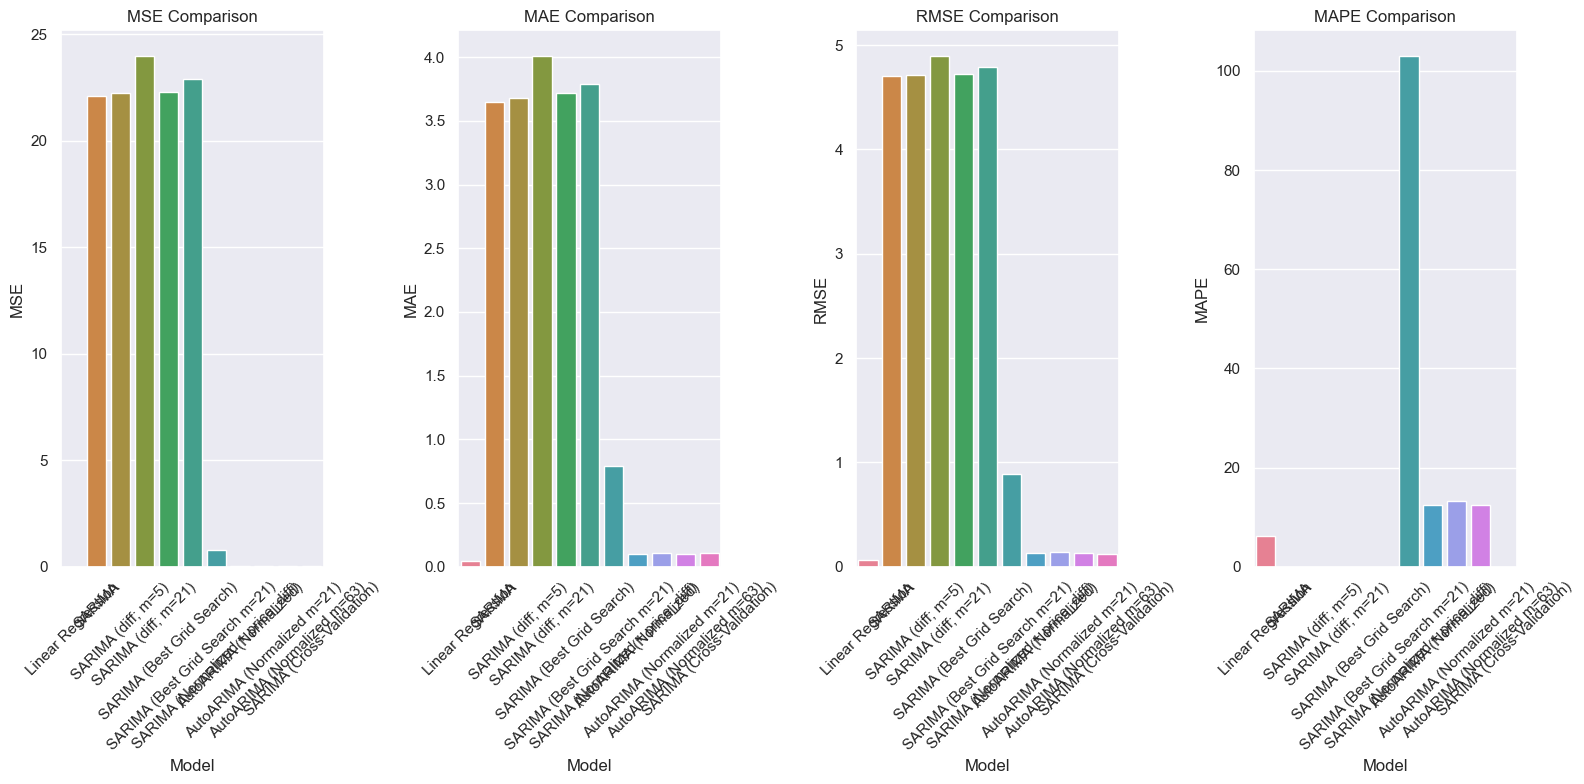

In [41]:
# Convert the dictionary into a DataFrame for visualization
metrics_df = pd.DataFrame(model_results).T
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# Define metrics to plot
metrics = ['MSE', 'MAE', 'RMSE', 'MAPE']

# Initialize the plot
plt.figure(figsize=(16, 8))

# Plot each metric
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, len(metrics), i)
    sns.barplot(data=metrics_df, x='Model', y=metric, palette='husl')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [42]:
metrics_df

,Model,MSE,MAE,RMSE,MAPE
0,Linear Regression,0.003700,0.046900,0.061200,6.250000
1,SARIMA,22.094368,3.651612,4.700465,inf
2,SARIMA (diff; m=5),22.240366,3.682726,4.715969,inf
3,SARIMA (diff; m=21),23.982929,4.009793,4.897237,inf
4,SARIMA (Best Grid Search),22.293958,3.716246,4.721648,inf
5,SARIMA (Best Grid Search m=21),22.909985,3.790050,4.786438,inf
6,SARIMA (Normalized + price_diff),0.797612,0.792468,0.893091,103.028513
7,AutoARIMA (Normalized),0.018348,0.101770,0.135455,12.445271
8,AutoARIMA (Normalized m=21),0.020561,0.108746,0.143390,13.321618
9,AutoARIMA (Normalized m=63),0.018348,0.101770,0.135455,12.445271


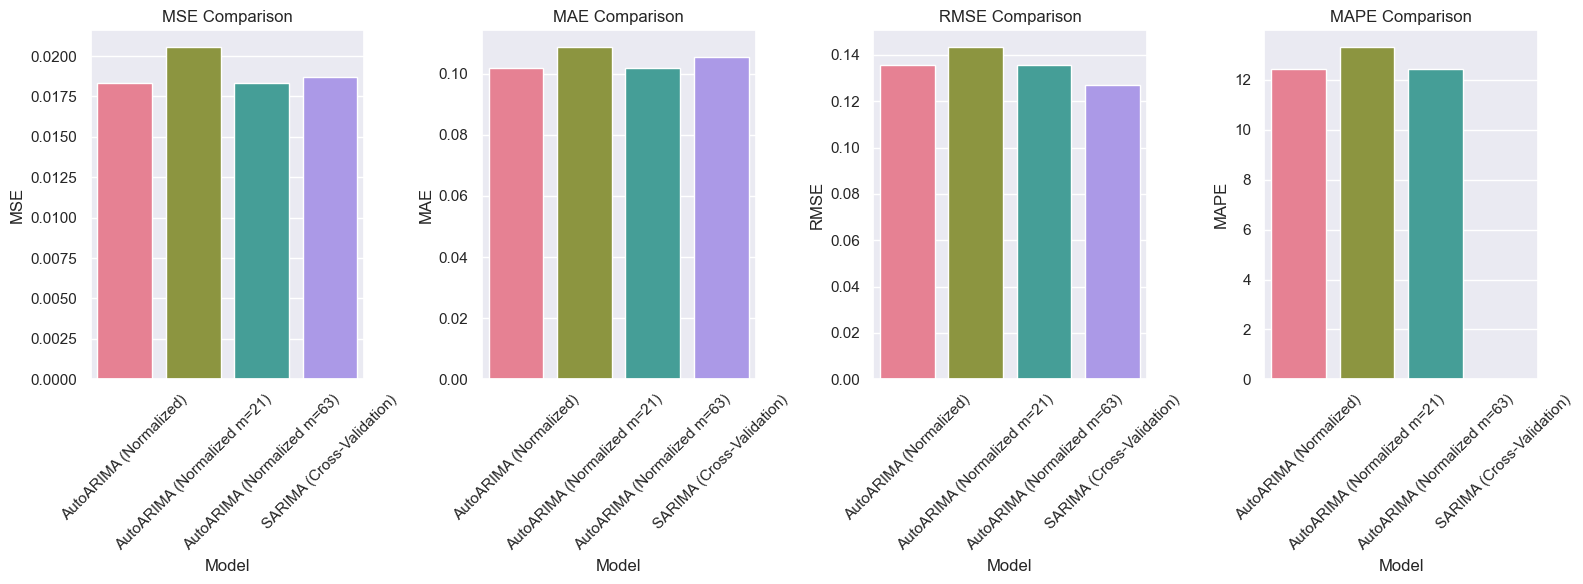

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter specific SARIMA models with normalized values
models_to_plot = ['AutoARIMA (Normalized)', 
                  'AutoARIMA (Normalized m=21)', 
                  'AutoARIMA (Normalized m=63)', 
                  'SARIMA (Cross-Validation)']

filtered_df = metrics_df[metrics_df['Model'].isin(models_to_plot)]

# Metrics to plot
metrics_to_plot = ['MSE', 'MAE', 'RMSE', 'MAPE']

# Plot each metric separately
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(16, 6), sharey=False)

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        data=filtered_df,
        x='Model',
        y=metric,
        ax=axes[i],
        palette='husl'
    )
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels

# Adjust layout
plt.tight_layout()
plt.show()



In [44]:
df

,I-CIP,price_standardized,price_normalized,price_diff,I-CIP_Standardised
date,,,,,
2023-02-02,172.50,-0.482921,0.209218,1.07,0.209218
2023-02-03,169.47,-0.578568,0.185305,-3.03,0.185305
2023-02-06,171.29,-0.521117,0.199669,1.82,0.199669
2023-02-07,172.14,-0.494285,0.206377,0.85,0.206377
2023-02-08,171.23,-0.523011,0.199195,-0.91,0.199195
...,...,...,...,...,...
2024-09-24,269.83,2.589469,0.977350,3.05,0.977350
2024-09-25,270.09,2.597677,0.979402,0.26,0.979402
2024-09-26,272.70,2.680066,1.000000,2.61,1.000000


In [50]:
train

date
2023-02-02    0.209218
2023-02-03    0.185305
2023-02-06    0.199669
2023-02-07    0.206377
2023-02-08    0.199195
                ...   
2024-05-24    0.568069
2024-05-27    0.558441
2024-05-28    0.642570
2024-05-29    0.640044
2024-05-30    0.667824
Name: price_normalized, Length: 346, dtype: float64

In [51]:
test

date
2024-05-31    0.589377
2024-06-03    0.624260
2024-06-04    0.664746
2024-06-05    0.676663
2024-06-06    0.686292
                ...   
2024-09-24    0.977350
2024-09-25    0.979402
2024-09-26    1.000000
2024-09-27    0.970563
2024-09-30    0.981612
Name: price_normalized, Length: 87, dtype: float64

In [53]:
import time


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-1393.161, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-1492.415, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-1392.123, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-1507.808, Time=0.41 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-1509.558, Time=0.33 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=-1494.269, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=-1507.762, Time=0.33 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=-1508.254, Time=0.63 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=-1507.737, Time=0.35 sec

Best model:  ARIMA(0,1,0)(2,1,0)[5]          
To

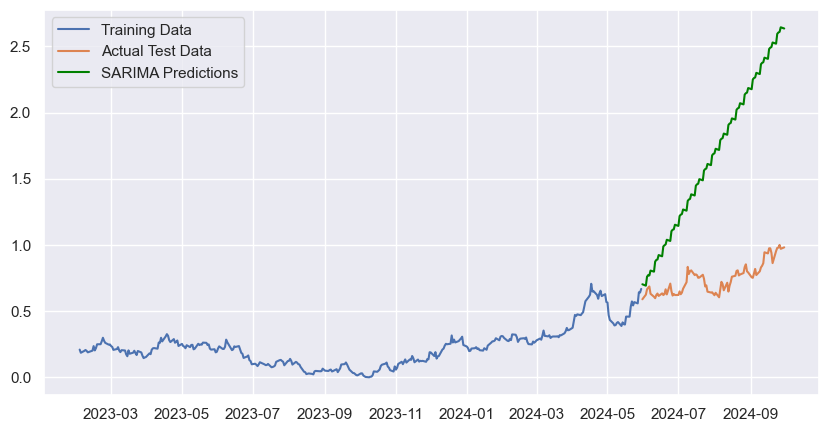

Mean Squared Error (MSE): 1.1110387814624394
Mean Absolute Error (MAE): 0.933974956926911
Root Mean Squared Error (RMSE): 1.0540582438662673


In [55]:
## USING AUTO ARIMA FOR FINDING BEST PARAM for norm prices

# Start timing
start_time = time.time()

# Run auto_arima to search for the best model
best_model = auto_arima(train,
                        start_p=0, max_p=3,  # Initial and max value for p
                        start_q=0, max_q=3,  # Initial and max value for q
                        start_P=0, max_P=2,  # Initial and max value for P
                        start_Q=0, max_Q=2,  # Initial and max value for Q
                        d=1, D=1,            # Non-seasonal and seasonal differencing
                        m=5,                # Seasonal period
                        seasonal=True,       # Whether to use seasonal ARIMA
                        stepwise=True,       # Whether to use stepwise algorithm
                        trace=True,          # Whether to print status on the fits
                        error_action='ignore',   # Don't want to know if an order does not work
                        suppress_warnings=True,  # Don't want convergence warnings
                        information_criterion='aic')  # Select best model based on AIC


# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"auto_arima running time: {elapsed_time:.2f} seconds")

# Summary of the best model
print(best_model.summary())


# Make predictions on the test set
predicted_means = best_model.predict(n_periods=len(test))  # This directly gives you the forecasted values

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train, label='Training Data')  # Make sure 'train' contains the appropriate date index if needed
plt.plot(test.index, test, label='Actual Test Data')  # Assuming 'test' is a DataFrame or Series with a date index
plt.plot(test.index, predicted_means, label='SARIMA Predictions', color='green')  # Ensure 'test.index' is used correctly
plt.legend()
plt.show()


# Calculate error metrics
mse = mean_squared_error(test, predicted_means)
mae = mean_absolute_error(test, predicted_means)
rmse = np.sqrt(mse)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Store cross-validation results in your metrics dictionary
add_model_results(
    model_name="SARIMA (AUTO ARIMA m=5)",
    mse=np.mean(mse),
    mae=np.mean(mae),
    rmse=np.mean(rmse),
    mape=None  # MAPE can be added 
)

In [58]:
df

,I-CIP,price_standardized,price_normalized,price_diff,I-CIP_Standardised
date,,,,,
2023-02-02,172.50,-0.482921,0.209218,1.07,0.209218
2023-02-03,169.47,-0.578568,0.185305,-3.03,0.185305
2023-02-06,171.29,-0.521117,0.199669,1.82,0.199669
2023-02-07,172.14,-0.494285,0.206377,0.85,0.206377
2023-02-08,171.23,-0.523011,0.199195,-0.91,0.199195
...,...,...,...,...,...
2024-09-24,269.83,2.589469,0.977350,3.05,0.977350
2024-09-25,270.09,2.597677,0.979402,0.26,0.979402
2024-09-26,272.70,2.680066,1.000000,2.61,1.000000


## LSTM - Long Term Short Memory


"Neural Networks are very complex machine learning models that pass input data through a network. Each node in the network learns a very simple operation. The neural network consists of many such nodes. The fact that the model can use a large number of simple nodes makes the overall prediction very complex. Neural Networks can therefore fit very complex and nonlinear data sets.  This can be useful for multiple use cases, including understanding time series (which are clearly sequences of values over time), but also text (sentences are sequences of words).

LSTMs are a specific type of RNNs. They have proven useful for time series forecasting on multiple occasions. They require some data and are more complicated to learn than supervised models. Once you master them, they can prove to be very powerful depending on your data and your specific use case." https://neptune.ai/blog/select-model-for-time-series-prediction-task

<i> "Long Short-Term Memory Networks is a deep learning, sequential neural network that allows information to persist. It is a special type of Recurrent Neural Network which is capable of handling the vanishing gradient problem faced by RNN. LSTM was designed by Hochreiter and Schmidhuber that resolves the problem caused by traditional rnns and machine learning algorithms. LSTM Model can be implemented in Python using the Keras library." 
(Saxena,2024)
    
    
    - ideal for prediction tasks
    
    
    
<b>The Logic Behind LSTM</b>
    
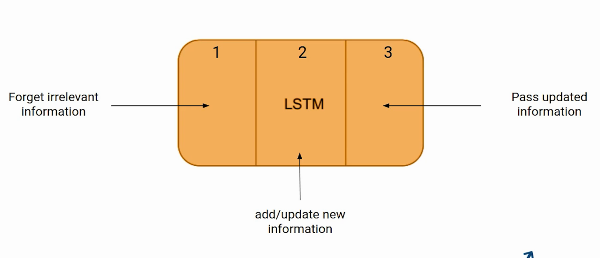
    
    
    The first part chooses whether the information coming from the previous timestamp is to be remembered or is irrelevant and can be forgotten. In the second part, the cell tries to learn new information from the input to this cell. At last, in the third part, the cell passes the updated information from the current timestamp to the next timestamp. This one cycle of LSTM is considered a single-time step.    
    
    
    . Neural Networks can therefore fit very complex and nonlinear data sets.
    
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/

### LSTM requires data to be scaled for better performance and avoiding under/overfitting.

The normalised prices were calculated with a min max scaler from 0-1, based on the mean and std variance, it is the common practice for this kind of modeling.


https://medium.com/@iqra1804/time-series-forecasting-using-lstm-an-introduction-with-code-explanations-c5c2e8ca137d

In [57]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 
# Using only 'price_normalized' as a feature for simplicity

# Reshape the features to [samples, time steps, features]
X = np.array(df['price_normalized']).reshape(-1, 1, 1)
y = df['price_normalized']


## LSTM (1)
### Splitting train/test 

In [59]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Building a simple version of the model with a single layer

In [60]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

### Compiling and training the model

In [61]:

# Start timing
start_time = time.time()



# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"LSTM running time: {elapsed_time:.2f} seconds")
## https://stackoverflow.com/questions/66576876/nameerror-name-history-is-not-defined

Epoch 1/100


2024-11-24 17:15:26.713390: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 2s 49ms/step - loss: 0.0405 - val_loss: 0.2495
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.1971
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.1418
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0932
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0690
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0719
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0761
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0689
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0568
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0486
Epoch 11/100
10/10 [

10/10 [==============================] - 0s 3ms/step - loss: 6.3061e-06 - val_loss: 3.8371e-04
Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 6.0693e-06 - val_loss: 3.4017e-04
Epoch 81/100
10/10 [==============================] - 0s 3ms/step - loss: 6.1013e-06 - val_loss: 3.8207e-04
Epoch 82/100
10/10 [==============================] - 0s 3ms/step - loss: 5.6701e-06 - val_loss: 3.7043e-04
Epoch 83/100
10/10 [==============================] - 0s 3ms/step - loss: 5.5232e-06 - val_loss: 3.3491e-04
Epoch 84/100
10/10 [==============================] - 0s 3ms/step - loss: 5.1512e-06 - val_loss: 3.0809e-04
Epoch 85/100
10/10 [==============================] - 0s 3ms/step - loss: 4.9380e-06 - val_loss: 2.8988e-04
Epoch 86/100
10/10 [==============================] - 0s 3ms/step - loss: 4.7730e-06 - val_loss: 2.9681e-04
Epoch 87/100
10/10 [==============================] - 0s 3ms/step - loss: 4.6675e-06 - val_loss: 2.7635e-04
Epoch 88/100
10/10 [=====================

### Plotting predictions

3/3 [==============================] - 0s 1ms/step


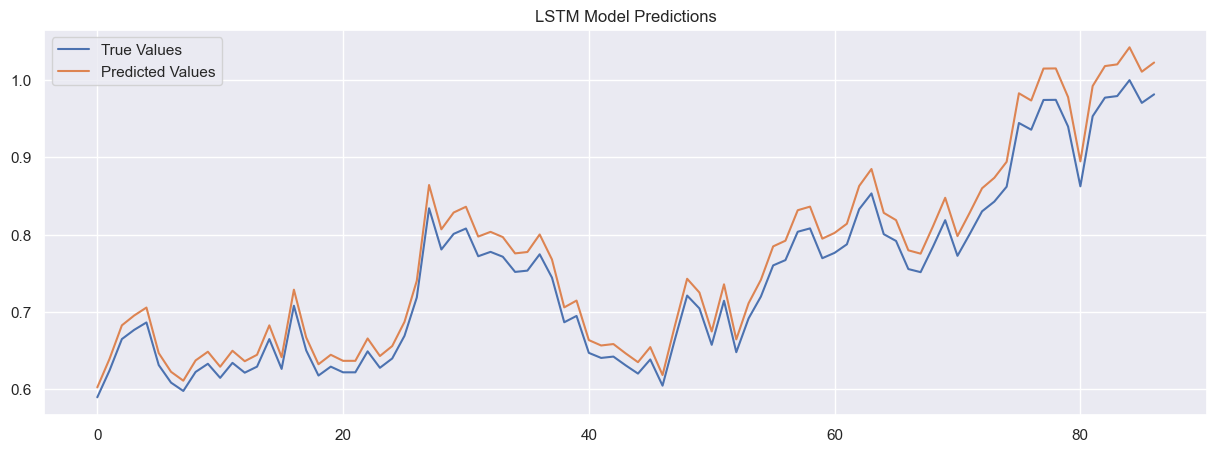

MSE: 0.0006219090785836755
RMSE: 0.02493810495173351
MAE: 0.023542252176815492


In [62]:
# Make predictions
predicted = model.predict(X_test)

# Plot
plt.figure(figsize=(15,5))
plt.plot(y_test.values.flatten(), label='True Values')
plt.plot(predicted.flatten(), label='Predicted Values')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()

# If scaling was applied, reverse the scaling on predictions


# Evaluate
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

### Learning Curve

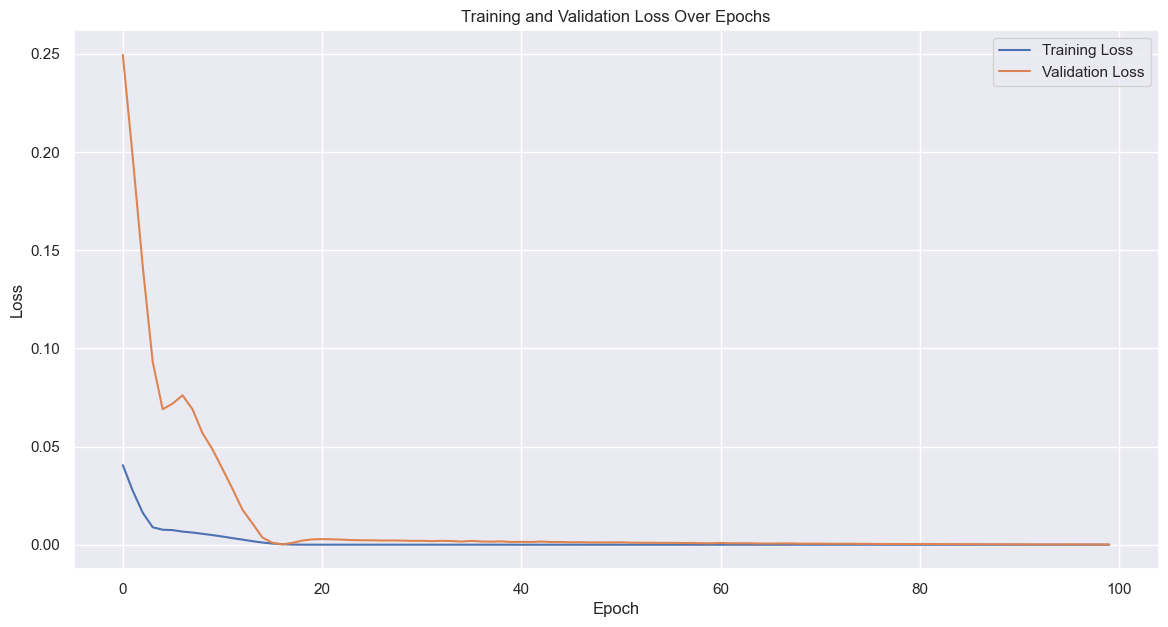

In [63]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:

# Store results
add_model_results('LSTM 1', mse, mae, rmse, mape)


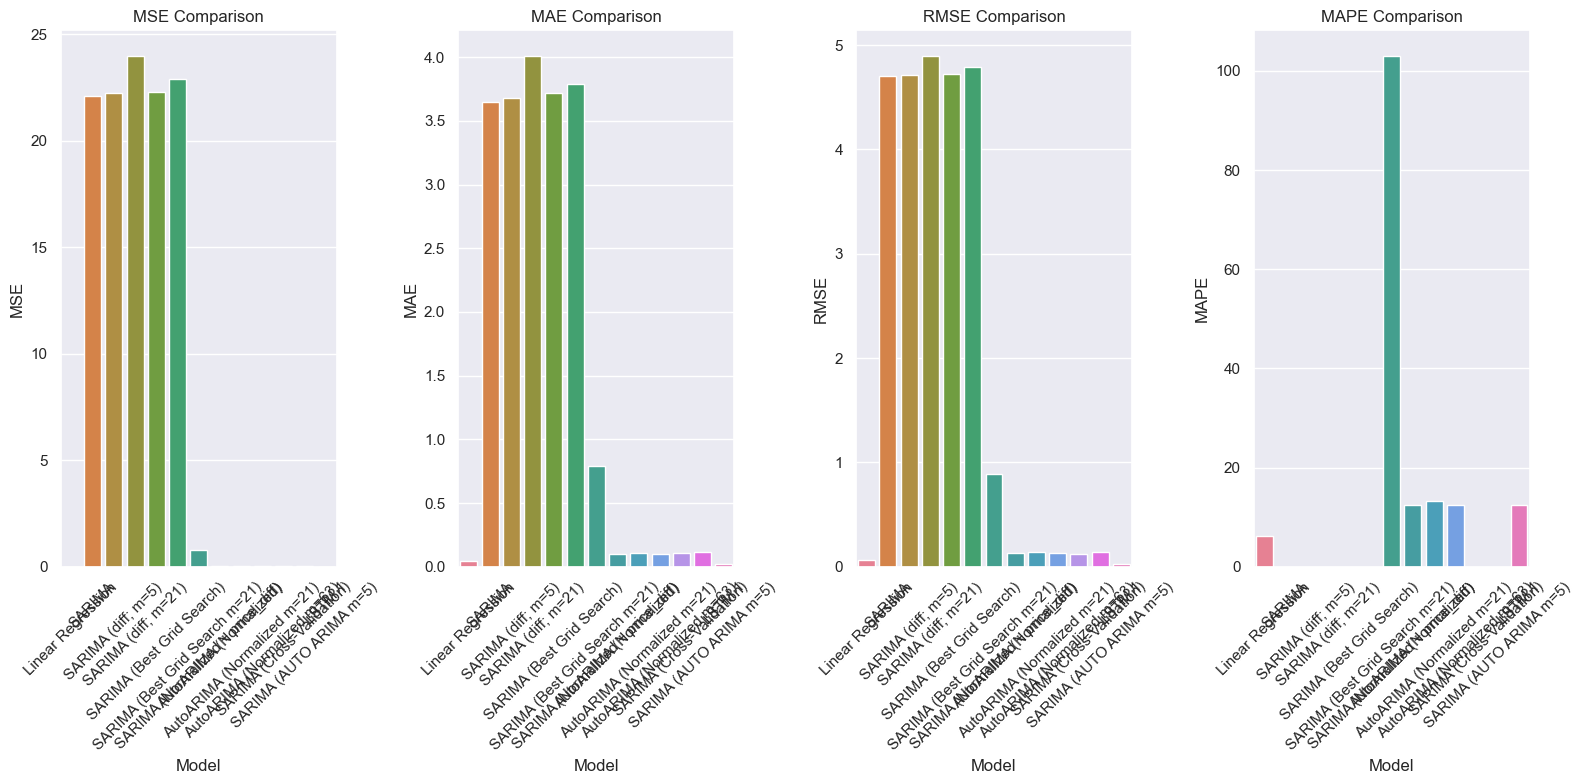

In [66]:
# Convert the dictionary into a DataFrame for visualization
metrics_df = pd.DataFrame(model_results).T
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# Define metrics to plot
metrics = ['MSE', 'MAE', 'RMSE', 'MAPE']

# Initialize the plot
plt.figure(figsize=(16, 8))

# Plot each metric
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, len(metrics), i)
    sns.barplot(data=metrics_df, x='Model', y=metric, palette='husl')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [67]:
metrics_df

,Model,MSE,MAE,RMSE,MAPE
0,Linear Regression,0.003700,0.046900,0.061200,6.250000
1,SARIMA,22.094368,3.651612,4.700465,inf
2,SARIMA (diff; m=5),22.240366,3.682726,4.715969,inf
3,SARIMA (diff; m=21),23.982929,4.009793,4.897237,inf
4,SARIMA (Best Grid Search),22.293958,3.716246,4.721648,inf
5,SARIMA (Best Grid Search m=21),22.909985,3.790050,4.786438,inf
6,SARIMA (Normalized + price_diff),0.797612,0.792468,0.893091,103.028513
7,AutoARIMA (Normalized),0.018348,0.101770,0.135455,12.445271
8,AutoARIMA (Normalized m=21),0.020561,0.108746,0.143390,13.321618
9,AutoARIMA (Normalized m=63),0.018348,0.101770,0.135455,12.445271


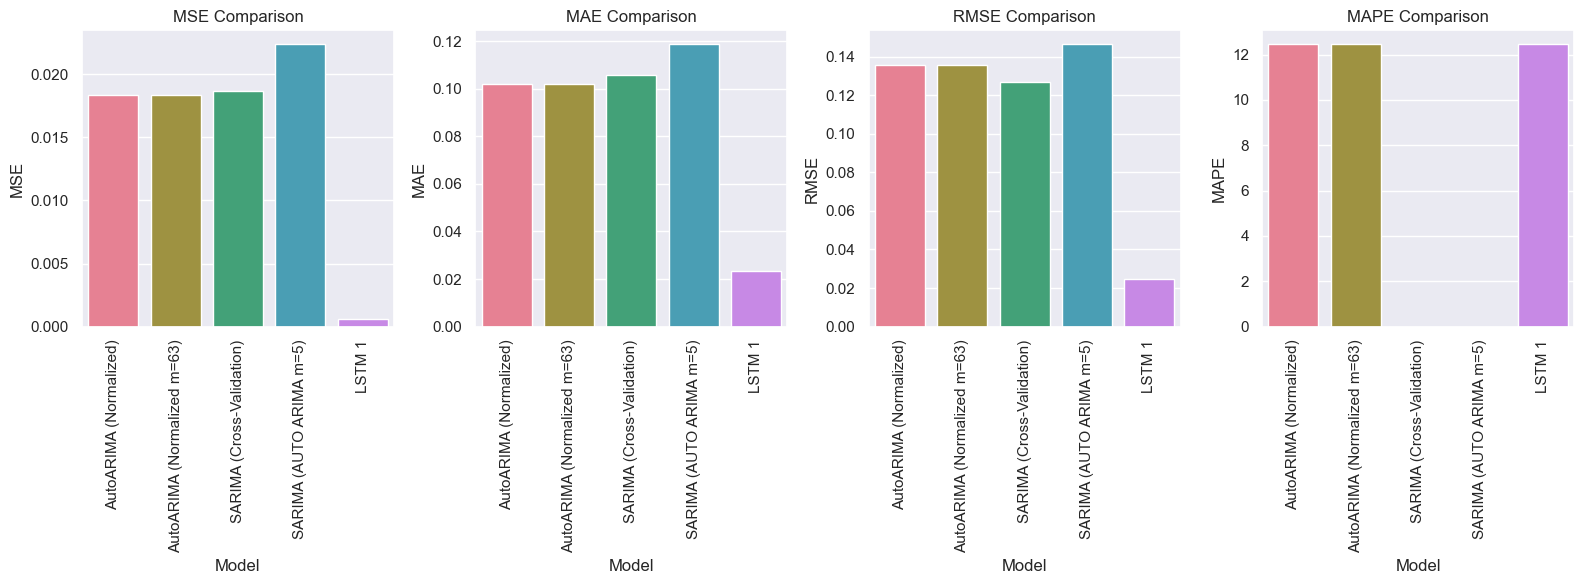

In [70]:
# Filter specific SARIMA models with normalized values
models_to_plot = ['AutoARIMA (Normalized)', 
                  'AutoARIMA (Normalized m=63)', 
                  'SARIMA (Cross-Validation)',
                 'SARIMA (AUTO ARIMA m=5)','LSTM 1']

filtered_df = metrics_df[metrics_df['Model'].isin(models_to_plot)]

# Metrics to plot
metrics_to_plot = ['MSE', 'MAE', 'RMSE', 'MAPE']

# Plot each metric separately
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(16, 6), sharey=False)

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        data=filtered_df,
        x='Model',
        y=metric,
        ax=axes[i],
        palette='husl'
    )
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=90)  # Rotate labels

# Adjust layout
plt.tight_layout()
plt.show()

## LSTM (2)
### Data prep for LSTM 

**1. Start TIme Series Data = ICIP prices (US$ per pd)**


In [71]:
# Extract the 'I-CIP' column as the target variable
data = df['I-CIP'].values.reshape(-1, 1)

**2. Scale data**

LSTM models need normalisation as they are sensitive to scale of input data. These values will be scaled back to their original for plotting results.


In [72]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

**3. Create Sliding Windows (Sequences)**



## window_size = 5

To structure the data, inputs(X) and outputs(y) sequences need to be created 


X: Contains sequences of a fixed length (first 5, then maybe 10 timesteps?).
y: The value immediately following each sequence.

In [73]:
def create_lstm_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])  # Past `window_size` values
        y.append(data[i + window_size, 0])   # The value after the sequence
    return np.array(X), np.array(y)

# Define the window size (number of timesteps)
window_size = 5

# Generate sequences
X, y = create_lstm_sequences(scaled_data, window_size)

**4. Reshape Input for LSTM (3 dimensions)**

The LSTM layer requires the input in the shape [samples, timesteps, features].

samples: Number of sliding windows created.
timesteps: Length of each sliding window.
features: Number of features (1 for univariate time series).


In [74]:
# Reshape X for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))


**5. Split the Data into Training (80%) and Testing Sets**

ensuring that the sequence order is preserved.


In [75]:
# Define the training size (80% of the data for training)
train_size = int(len(X) * 0.8)

# Split into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (342, 5, 1), y_train shape: (342,)
X_test shape: (86, 5, 1), y_test shape: (86,)


In [77]:
import tensorflow as tf

## 20 epochs 

Epoch 1/20
11/11 [==============================] - 1s 27ms/step - loss: 0.0502 - mae: 0.1781 - val_loss: 0.2679 - val_mae: 0.5092
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0148 - mae: 0.0877 - val_loss: 0.0734 - val_mae: 0.2606
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0089 - mae: 0.0792 - val_loss: 0.0379 - val_mae: 0.1834
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0063 - mae: 0.0639 - val_loss: 0.0462 - val_mae: 0.2057
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0050 - mae: 0.0526 - val_loss: 0.0326 - val_mae: 0.1715
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0451 - val_loss: 0.0078 - val_mae: 0.0744
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0024 - mae: 0.0388 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0017 - mae: 0.0

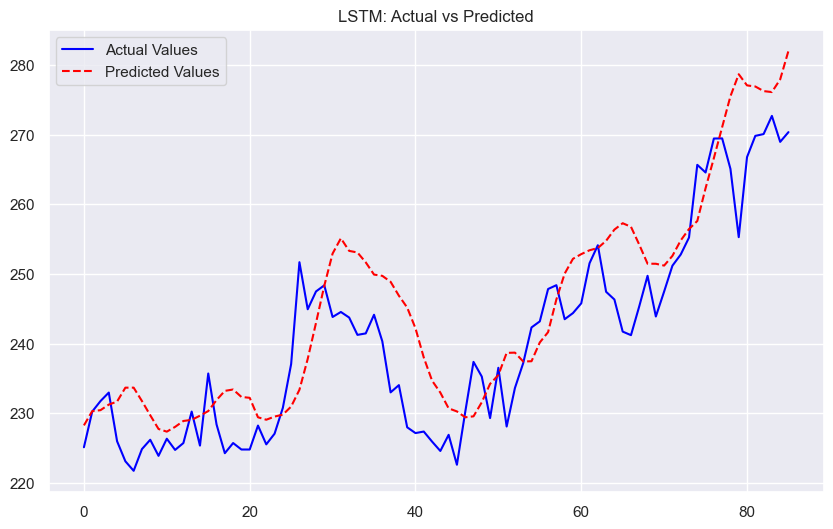

Performance Metrics:
MSE: 64.3637, MAE: 6.4948, RMSE: 8.0227


In [78]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
scaled_predictions = predictions.flatten()
original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(original_y_test, label='Actual Values', color='blue')
plt.plot(original_predictions, label='Predicted Values', color='red', linestyle='--')
plt.legend()
plt.title("LSTM: Actual vs Predicted")
plt.show()

# Calculate error metrics
mse = mean_squared_error(original_y_test, original_predictions)
mae = mean_absolute_error(original_y_test, original_predictions)
rmse = np.sqrt(mse)
print(f"Performance Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


## Same code but now with **100** epochs 

Epoch 1/100
11/11 [==============================] - 1s 44ms/step - loss: 0.0374 - mae: 0.1502 - val_loss: 0.1645 - val_mae: 0.3974
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0079 - mae: 0.0692 - val_loss: 0.0238 - val_mae: 0.1411
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0075 - mae: 0.0749 - val_loss: 0.0321 - val_mae: 0.1687
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0044 - mae: 0.0511 - val_loss: 0.0322 - val_mae: 0.1705
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0032 - mae: 0.0428 - val_loss: 0.0098 - val_mae: 0.0858
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0023 - mae: 0.0378 - val_loss: 0.0030 - val_mae: 0.0421
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0016 - mae: 0.0309 - val_loss: 0.0027 - val_mae: 0.0406
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0015 - 

11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0020 - val_mae: 0.0366
Epoch 64/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0020 - val_mae: 0.0358
Epoch 65/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0020 - val_mae: 0.0362
Epoch 66/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 67/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0020 - val_mae: 0.0353
Epoch 68/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0235 - val_loss: 0.0019 - val_mae: 0.0358
Epoch 69/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0020 - val_mae: 0.0354
Epoch 70/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0

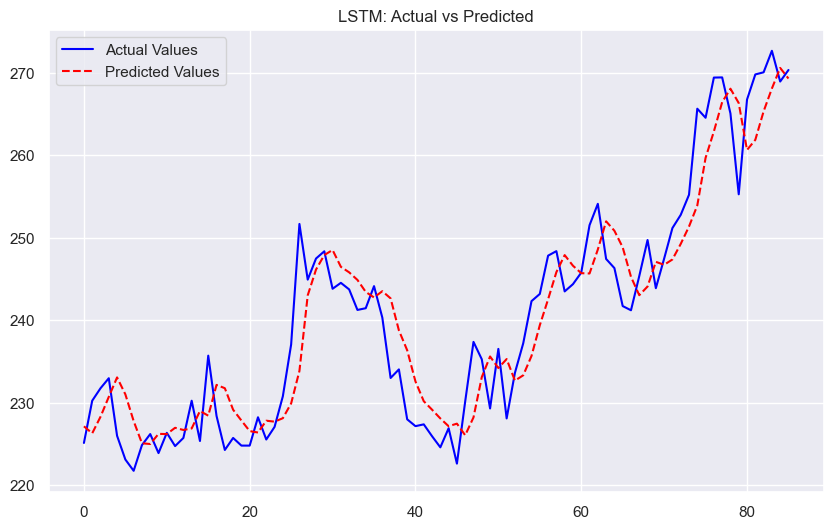

Performance Metrics:
MSE: 25.4112, MAE: 4.1142, RMSE: 5.0409


In [79]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
scaled_predictions = predictions.flatten()
original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(original_y_test, label='Actual Values', color='blue')
plt.plot(original_predictions, label='Predicted Values', color='red', linestyle='--')
plt.legend()
plt.title("LSTM: Actual vs Predicted")
plt.show()

# Calculate error metrics
mse = mean_squared_error(original_y_test, original_predictions)
mae = mean_absolute_error(original_y_test, original_predictions)
rmse = np.sqrt(mse)
print(f"Performance Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

## 200 epochs?

Epoch 1/200
11/11 [==============================] - 2s 34ms/step - loss: 0.0488 - mae: 0.1749 - val_loss: 0.2357 - val_mae: 0.4771
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0128 - mae: 0.0830 - val_loss: 0.0551 - val_mae: 0.2242
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0080 - mae: 0.0759 - val_loss: 0.0282 - val_mae: 0.1564
Epoch 4/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0609 - val_loss: 0.0383 - val_mae: 0.1865
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0041 - mae: 0.0486 - val_loss: 0.0202 - val_mae: 0.1318
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0418 - val_loss: 0.0071 - val_mae: 0.0705
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0360 - val_loss: 0.0032 - val_mae: 0.0434
Epoch 8/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0017 - 

11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0020 - val_mae: 0.0360
Epoch 64/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0020 - val_mae: 0.0364
Epoch 65/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 0.0021 - val_mae: 0.0362
Epoch 66/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0021 - val_mae: 0.0372
Epoch 67/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 68/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0020 - val_mae: 0.0369
Epoch 69/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 70/200
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0

Epoch 124/200
11/11 [==============================] - 0s 4ms/step - loss: 7.7973e-04 - mae: 0.0213 - val_loss: 0.0034 - val_mae: 0.0452
Epoch 125/200
11/11 [==============================] - 0s 4ms/step - loss: 6.9785e-04 - mae: 0.0200 - val_loss: 0.0028 - val_mae: 0.0402
Epoch 126/200
11/11 [==============================] - 0s 4ms/step - loss: 6.8230e-04 - mae: 0.0198 - val_loss: 0.0032 - val_mae: 0.0439
Epoch 127/200
11/11 [==============================] - 0s 4ms/step - loss: 6.7845e-04 - mae: 0.0198 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 128/200
11/11 [==============================] - 0s 4ms/step - loss: 7.4696e-04 - mae: 0.0209 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 129/200
11/11 [==============================] - 0s 4ms/step - loss: 7.9287e-04 - mae: 0.0213 - val_loss: 0.0032 - val_mae: 0.0436
Epoch 130/200
11/11 [==============================] - 0s 4ms/step - loss: 7.1688e-04 - mae: 0.0205 - val_loss: 0.0065 - val_mae: 0.0686
Epoch 131/200
11/11 [====================

Epoch 184/200
11/11 [==============================] - 0s 4ms/step - loss: 6.2261e-04 - mae: 0.0192 - val_loss: 0.0047 - val_mae: 0.0558
Epoch 185/200
11/11 [==============================] - 0s 4ms/step - loss: 6.1486e-04 - mae: 0.0192 - val_loss: 0.0038 - val_mae: 0.0490
Epoch 186/200
11/11 [==============================] - 0s 4ms/step - loss: 6.2355e-04 - mae: 0.0189 - val_loss: 0.0026 - val_mae: 0.0391
Epoch 187/200
11/11 [==============================] - 0s 4ms/step - loss: 6.2885e-04 - mae: 0.0190 - val_loss: 0.0023 - val_mae: 0.0363
Epoch 188/200
11/11 [==============================] - 0s 4ms/step - loss: 6.3877e-04 - mae: 0.0194 - val_loss: 0.0033 - val_mae: 0.0453
Epoch 189/200
11/11 [==============================] - 0s 4ms/step - loss: 6.1837e-04 - mae: 0.0190 - val_loss: 0.0031 - val_mae: 0.0438
Epoch 190/200
11/11 [==============================] - 0s 4ms/step - loss: 6.2214e-04 - mae: 0.0189 - val_loss: 0.0023 - val_mae: 0.0368
Epoch 191/200
11/11 [====================

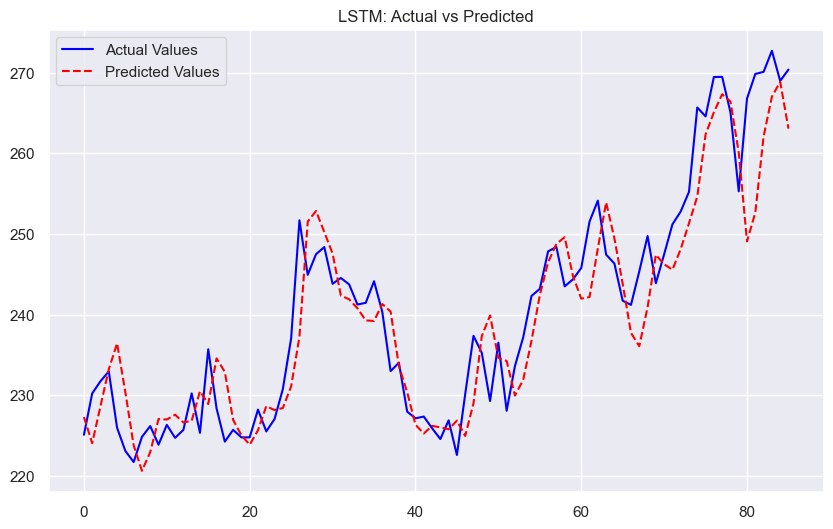

Performance Metrics:
MSE: 31.4416, MAE: 4.3046, RMSE: 5.6073


In [80]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
scaled_predictions = predictions.flatten()
original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(original_y_test, label='Actual Values', color='blue')
plt.plot(original_predictions, label='Predicted Values', color='red', linestyle='--')
plt.legend()
plt.title("LSTM: Actual vs Predicted")
plt.show()

# Calculate error metrics
mse = mean_squared_error(original_y_test, original_predictions)
mae = mean_absolute_error(original_y_test, original_predictions)
rmse = np.sqrt(mse)
print(f"Performance Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

## Testing with window of 10 timesteps to capture long-term dependencies betweeen data 

Epoch 1/100
11/11 [==============================] - 2s 49ms/step - loss: 0.0246 - val_loss: 0.0048
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0499
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 11

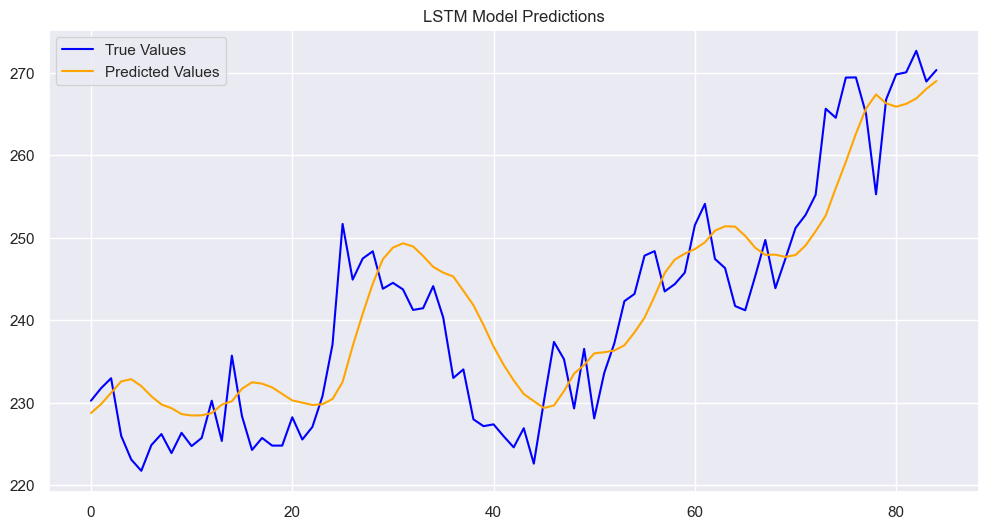

Performance Metrics:
MSE: 41.4953, MAE: 5.3886, RMSE: 6.4417


In [81]:
from tensorflow.keras.callbacks import EarlyStopping

# Window size
window_size = 10  # Adjust as needed

# Recreate sliding windows
X, y = create_lstm_sequences(scaled_data, window_size)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test)

# Inverse transform predictions
scaled_predictions = predictions.flatten()
original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(original_y_test, label='True Values', color='blue')
plt.plot(original_predictions, label='Predicted Values', color='orange')
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()

# Calculate error metrics
mse = mean_squared_error(original_y_test, original_predictions)
mae = mean_absolute_error(original_y_test, original_predictions)
rmse = np.sqrt(mse)
print(f"Performance Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Epoch 1/100
11/11 [==============================] - 7s 117ms/step - loss: 0.0288 - val_loss: 0.0627
Epoch 2/100
11/11 [==============================] - 0s 33ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 3/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 4/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 5/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0025 - val_loss: 0.0127
Epoch 6/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0028 - val_loss: 0.0131
Epoch 7/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 8/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0023 - val_loss: 0.0080
Epoch 9/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 10/100
11/11 [==============================] - 0s 33ms/step - loss: 0.0019 - val_loss: 0.003

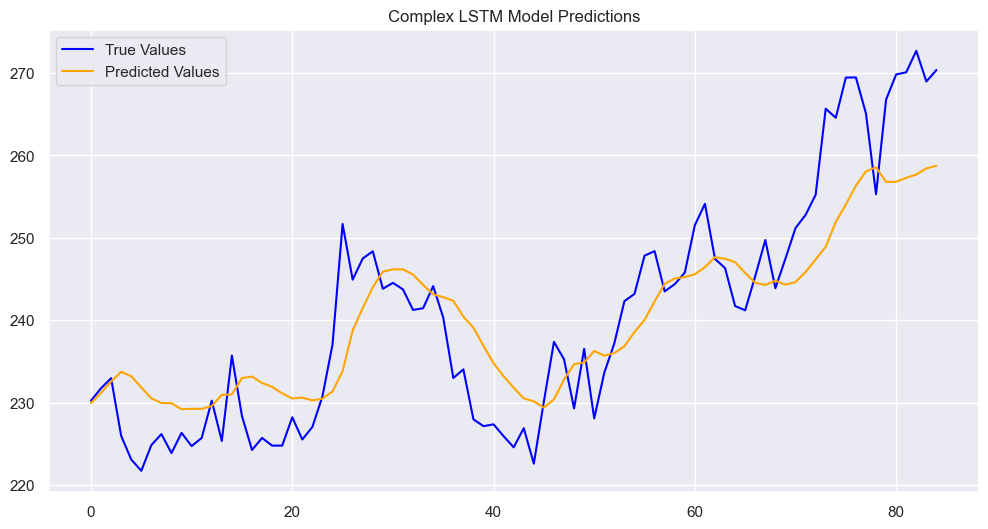

Complex LSTM Model Metrics:
MSE: 50.1084, MAE: 5.7710, RMSE: 7.0787


In [82]:
from tensorflow.keras.layers import Dropout, Bidirectional

# Define a more complex LSTM model
complex_model = tf.keras.Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(window_size, 1))),
    Dropout(0.2),  # Add dropout for regularization
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(50, activation='relu'),  # Add a Dense layer with ReLU activation
    Dense(1)  # Output layer
])

# Compile the model
complex_model.compile(optimizer='adam', loss='mse')

# Train the model
history = complex_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
complex_loss = complex_model.evaluate(X_test, y_test, verbose=0)
complex_predictions = complex_model.predict(X_test)

# Inverse transform predictions
complex_scaled_predictions = complex_predictions.flatten()
complex_original_predictions = scaler.inverse_transform(complex_scaled_predictions.reshape(-1, 1))
complex_original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(complex_original_y_test, label='True Values', color='blue')
plt.plot(complex_original_predictions, label='Predicted Values', color='orange')
plt.legend()
plt.title("Complex LSTM Model Predictions")
plt.show()

# Calculate error metrics
complex_mse = mean_squared_error(complex_original_y_test, complex_original_predictions)
complex_mae = mean_absolute_error(complex_original_y_test, complex_original_predictions)
complex_rmse = np.sqrt(complex_mse)
print(f"Complex LSTM Model Metrics:\nMSE: {complex_mse:.4f}, MAE: {complex_mae:.4f}, RMSE: {complex_rmse:.4f}")


## GRU? 

In [ ]:
# Define the GRU model
gru_model = tf.keras.Sequential([
    GRU(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
gru_loss = gru_model.evaluate(X_test, y_test, verbose=0)
gru_predictions = gru_model.predict(X_test)

# Inverse transform predictions
gru_scaled_predictions = gru_predictions.flatten()
gru_original_predictions = scaler.inverse_transform(gru_scaled_predictions.reshape(-1, 1))
gru_original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(gru_original_y_test, label='True Values', color='blue')
plt.plot(gru_original_predictions, label='Predicted Values', color='orange')
plt.legend()
plt.title("GRU Model Predictions")
plt.show()

# Calculate error metrics
gru_mse = mean_squared_error(gru_original_y_test, gru_original_predictions)
gru_mae = mean_absolute_error(gru_original_y_test, gru_original_predictions)
gru_rmse = np.sqrt(gru_mse)
print(f"GRU Model Metrics:\nMSE: {gru_mse:.4f}, MAE: {gru_mae:.4f}, RMSE: {gru_rmse:.4f}")
